In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [41]:
model = nn.Sequential(nn.Linear(5,128),nn.ReLU(),
                      nn.Linear(128,256),nn.ReLU(),
                      nn.Linear(256,128),nn.ReLU(),
                      nn.Linear(128,50),nn.Sigmoid(),
                      nn.Linear(50,1))
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [48]:
class Dataset(Dataset):
    def __init__(self):
        test = pd.read_csv('data/train.csv')
        del test['Ticket']
        del test['Fare']
        del test['Cabin']
        del test['Name']
        del test['Embarked']
        test['Sex'] = test['Sex'].replace({"male": 0, "female": 1}).astype(np.int8)
        test['Age'] = test['Age'].fillna(value=test['Age'].median())
        self.data = test
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        target = self.data.iloc[index].tolist()[1]
        sample = self.data.iloc[index].tolist()[2:]
        
        target = torch.tensor(target)
        sample = torch.tensor(sample)
        return target, sample

In [26]:
data = Dataset()
train_set, val_set= random_split(data,[0.9,0.1])
train_loader = DataLoader(train_set,batch_size = 8, shuffle= True)
val_loader = DataLoader(val_set,batch_size = 8, shuffle= False)

C:\Users\admin\AppData\Local\Temp\ipykernel_6820\3865981479.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['Sex'] = test['Sex'].replace({"male": 0, "female": 1}).astype(np.int8)


In [44]:
train_loss = []
val_loss = []
accuracy_train =[]
accuracy_val =[]

In [45]:
for i in range(10):
    model.train()
    
    train_loop = tqdm(train_loader,leave=True)
    correct = 0 
    total = 0
    mean_loss = []
    
    for target, x in train_loop:
        
        target = target.unsqueeze(1)
        pred = model(x)
        loss = loss_fn(pred,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        mean_loss.append(loss.item())
        train_loop.set_description(f"Epohs:{i} loss: {loss.item():.4f}")
        
    train_loss.append(sum(mean_loss) / len(mean_loss))
    mean_loss =[]
    with torch.no_grad():
        model.eval()
        val_loop = tqdm(val_loader,leave=True)
        for target, x in val_loop:
            
            target = target.unsqueeze(1)
            pred = model(x)
            loss = loss_fn(pred,target)
            mean_loss.append(loss.item())
            val_loop.set_description(f"Epohs:{i} loss: {loss.item():.4f}")
        
    val_loss.append(sum(mean_loss) / len(mean_loss))
    

Epohs:9 loss: 0.7736: 100%|██████████| 12/12 [00:00<00:00, 705.04it/s]


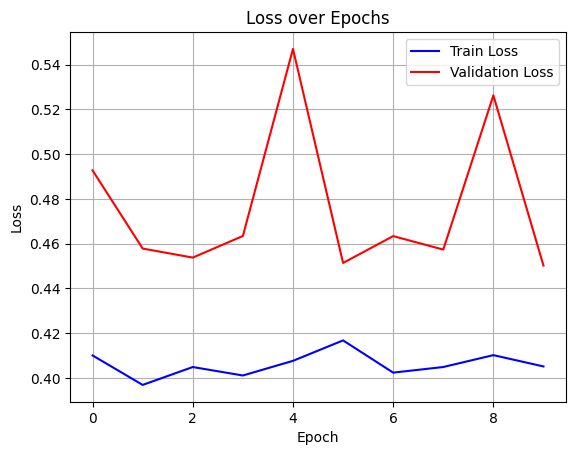

In [46]:
# Построение графика
plt.plot(train_loss, label='Train Loss', color='blue')  # Синим график обучающих потерь
plt.plot(val_loss, label='Validation Loss', color='red')   # Отображаем график потерь
plt.xlabel('Epoch')  # Подпись оси X (например, эпохи)
plt.ylabel('Loss')  # Подпись оси Y (значения потерь)
plt.title('Loss over Epochs')  # Заголовок графика
plt.legend()  # Легенда
plt.grid(True)  # Включение сетки
plt.show() 

In [58]:
data1 = Dataset()
target, sample =data1[102]
print(sample)
print(target)
out = model(sample)
out = torch.clamp(out, 0, 1)
print(torch.round(out))

tensor([ 1.,  0., 21.,  0.,  1.])
tensor(0.)
tensor([0.], grad_fn=<RoundBackward0>)


C:\Users\admin\AppData\Local\Temp\ipykernel_6820\3865981479.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['Sex'] = test['Sex'].replace({"male": 0, "female": 1}).astype(np.int8)
